In [6]:
import os
import hydromt
from hydromt import DataCatalog
from hydromt_sfincs import SfincsModel, utils
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs

In [7]:

def calculate_stats(station_id, df, tstart=None, tend=None):
    if tstart:
        df = df[df.index > tstart]
    if tend:
        df = df[df.index < tend]

    n = len(df)
    # Mean Absolute Error
    mae = sum(abs(df.Modeled - df.Observed)) / n
    # Mean Error or Bias
    bias = sum(df.Modeled - df.Observed) / n
    # Root Mean Squared Error
    rmse = sum(((df.Observed - df.Modeled) ** 2) / n) ** 0.5
    # Peak Error
    pe = df.Modeled.max() - df.Observed.max()
    # Time to Peak - Error
    tpe = df.Modeled.idxmax() - df.Observed.idxmax()
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (sum((df.Modeled - df.Observed) ** 2) / sum((df.Observed - df.Observed.mean()) ** 2))
    # Correlation Coefficient (Pearson)
    try:
        r = sum(((df.Modeled - df.Modeled.mean()) * (df.Observed - df.Observed.mean()))) / (
                sum((df.Modeled - df.Modeled.mean()) ** 2) * sum((df.Observed - df.Observed.mean()) ** 2)) ** 0.5
    except:
        print('Correlation Coefficient problem')
        r = 0

    # Coefficient of Determination
    r2 = r ** 2

    # Save stats in a dataframe for output
    stats = pd.DataFrame(data={'station_id': station_id,
                               'mae': round(mae, 2),
                               'rmse': round(rmse, 2),
                               'nse': round(nse, 2),
                               'bias': round(bias, 2),
                               'r': round(r, 2),
                               'r2': round(r2, 2),
                               'pe': round(pe, 2),
                               'tpe': round(tpe.seconds, 1),
                               'mod_peak_wl': round(df.Modeled.max(), 2),
                               'obs_peak_wl': round(df.Observed.max(), 2)
                               },
                         index=[0]
                         )
    peak_dt = [df.Observed.idxmax(), df.Modeled.idxmax()]

    return stats, peak_dt



def clean_obs_coords(obs_df, source_crs, target_crs):
    # Clean up the observation data and the coordinates
    if 'geometry' in list(obs_df.coords):
        pts = gpd.GeoDataFrame(obs_df.station.values,
                               geometry=obs_df.geometry.values,
                               crs=source_crs)
        pts.to_crs(target_crs, inplace=True)
        pts.columns = ['site_no', 'geometry']
        obs_df.geometry.values = pts.geometry
    else:
        pts = gpd.GeoDataFrame(obs_df.station,
                               geometry=gpd.points_from_xy(x=obs_df.x.values,
                                                           y=obs_df.y.values,
                                                           crs=source_crs))
        pts.to_crs(target_crs, inplace=True)
        pts.columns = ['site_no', 'geometry']
        obs_df.x.values = pts.geometry.x
        obs_df.y.values = pts.geometry.y

    return pts, obs_df

In [8]:
# Load data catalog and model results
model_root = r'Z:\users\lelise\projects\Carolinas_SFINCS\Chapter1_FlorenceValidation\sfincs_models\mod_v4_flor' \
             r'\ENC_200m_sbg5m_avgN_adv1_eff75'
mod = SfincsModel(root=model_root, mode='r')
cat = mod.data_catalog
mod.read_results(fn_his=r'Z:\users\lelise\sfincs_his.nc')
print(mod.results.keys())

dict_keys(['inp', 'msk', 'qinf', 'zb', 'zs', 'Seff', 'zsmax', 'tmax', 'vmax', 'total_runtime', 'average_dt', 'point_zb', 'structure_height', 'point_zs', 'point_qinf', 'point_S', 'status'])


In [9]:
# Get the station data for querying SFINCS results
mod_zs_da = mod.results['point_zs']
mod_zs_lookup = pd.DataFrame()
mod_zs_lookup['station_id'] = mod_zs_da['station_id'].values
mod_zs_lookup['station_name'] = [x.decode('utf-8').strip() for x in mod_zs_da['station_name'].values]
mod_zs_lookup['data_source'] = [x.rsplit('_', 1)[0] for x in mod_zs_lookup['station_name']]
mod_zs_lookup['data_source_id'] = [x.split('_')[-1] for x in mod_zs_lookup['station_name']]

In [10]:
# LOAD THE OBSERVED WATER LEVEL TIMESERIES
agency ='USGS'
obs_dataset = r'Z:\users\lelise\data\storm_data\hurricanes\2024_debby\waterlevel\usgs_waterlevel_debby_DATA.nc'
obs_da = cat.get_geodataset(obs_dataset, geom=mod.region, variables=["waterlevel"], crs=4326)

pts, obs = clean_obs_coords(obs_df=obs_da, source_crs=4326, target_crs=mod.crs.to_epsg())

# Loop through the observation locations and extract model data
mod_zs_lookup_sub = mod_zs_lookup[mod_zs_lookup['data_source'] == agency]

In [11]:
# Create empty lists/df to save information to when looping through the observation gages
calculate_gage_stats = True
if calculate_gage_stats is True:
    station_stats = pd.DataFrame()
    invalid_obs, valid_obs = [], []
    for index, row in mod_zs_lookup_sub.iterrows():
        data_source_id = int(row['data_source_id'])
        if data_source_id in obs_da.station.values.tolist():
            obs_zs = obs.sel(station=data_source_id)
            mod_zs = mod_zs_da.sel(stations=index)

            # Add observed and modeled data into a single dataframe
            obs_df = pd.DataFrame(data=obs_zs.values, index=obs_zs.time.values, columns=['Observed'])
            mod_df = pd.DataFrame(data=mod_zs.values, index=mod_zs.time.values, columns=['Modeled'])
            merged_df = pd.concat([obs_df, mod_df], axis=1)
            merged_df.dropna(inplace=True)

            # If the dataframe is empty or there are fewer than 20 observation points,
            # append the gage ID to the list of "invalid_obs"
            if merged_df.empty or len(merged_df) < 50:
                print(f'No data for gage: {data_source_id}')
                invalid_obs.append(data_source_id)
            else:
                valid_obs.append(data_source_id)

            # Calculate the hydrograph stats at the station and add to master dataframe
            ss, _ = calculate_stats(station_id=data_source_id, df=merged_df, tstart=None, tend=None)
            ss['source'] = agency
            station_stats = pd.concat([station_stats, ss], ignore_index=True)

station_stats.set_index('station_id', drop=True, inplace=True)
pts.set_index('site_no', drop=True, inplace=True)
stats_out = pd.concat([pts, station_stats], axis=1, ignore_index=False)
stats_out = gpd.GeoDataFrame(stats_out, geometry='geometry', crs=mod.crs)
stats_out['x'] = stats_out.geometry.x
stats_out['y'] = stats_out.geometry.y

In [56]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(stats_out)

                                 geometry   mae  rmse       nse  bias     r  \
2135615    POINT (572241.562 3732452.522)  0.22  0.24    -69.92  0.22 -0.61   
2136030    POINT (635111.360 3706606.186)  1.77  1.77   -236.32  1.77  0.98   
2136000    POINT (607929.397 3725207.680)  0.26  0.31     -3.10  0.26  0.05   
21355015   POINT (578519.214 3741748.696)  0.21  0.30    -36.46  0.13 -0.60   
2135501    POINT (580353.344 3744077.225)  0.38  0.42     -4.40 -0.38  0.07   
2132200    POINT (643536.721 3745516.299)   NaN   NaN       NaN   NaN   NaN   
2131210    POINT (644619.802 3752566.872)   NaN   NaN       NaN   NaN   NaN   
2131510    POINT (593587.789 3766854.428)  0.76  0.91    -19.93 -0.76 -0.40   
2131500    POINT (572402.089 3790172.801)  0.65  0.79     -2.94 -0.57 -0.07   
2131472    POINT (538288.278 3819479.770)  0.64  0.68   -525.58  0.64  0.78   
2131455    POINT (541610.995 3823375.369)  1.78  1.79  -5287.90 -1.78  0.03   
21313485   POINT (549805.536 3826848.660)  0.78  0.7

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(mod_zs_lookup_sub)

     station_id    station_name data_source data_source_id
0           1.0    USGS_2136361        USGS        2136361
1           2.0    USGS_2136350        USGS        2136350
2           3.0    USGS_2110815        USGS        2110815
4           5.0   USGS_21108125        USGS       21108125
6           7.0    USGS_2110802        USGS        2110802
7           8.0    USGS_2136030        USGS        2136030
9          10.0    USGS_2136000        USGS        2136000
10         11.0    USGS_2135615        USGS        2135615
11         12.0   USGS_21355015        USGS       21355015
12         13.0    USGS_2135501        USGS        2135501
15         16.0    USGS_2135200        USGS        2135200
16         17.0    USGS_2110725        USGS        2110725
17         18.0    USGS_2110704        USGS        2110704
19         20.0    USGS_2110550        USGS        2110550
20         21.0    USGS_2110701        USGS        2110701
21         22.0    USGS_2135000        USGS        21350

In [108]:
data_source_id = 2098206   

# Load the observed and modeled data for the select gage
obs_zs = obs.sel(station=data_source_id)
print(obs_zs)

<xarray.DataArray 'waterlevel' (time: 4048)>
dask.array<getitem, shape=(4048,), dtype=float64, chunksize=(4048,), chunktype=numpy.ndarray>
Coordinates:
    station      int32 2098206
    x            float64 6.757e+05
    y            float64 3.945e+06
  * time         (time) datetime64[ns] 2024-07-20 ... 2024-08-31T03:45:00
    spatial_ref  int32 0
Attributes:
    units:    m


In [109]:
# Get the model data
index = mod_zs_lookup_sub[mod_zs_lookup_sub['data_source_id'] == f'{data_source_id}'].index.item()
mod_zs = mod_zs_da.sel(stations=index)
print(mod_zs)
print(mod_zs.station_name.values)

<xarray.DataArray 'point_zs' (time: 241)>
dask.array<getitem, shape=(241,), dtype=float32, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
    station_id    float32 dask.array<chunksize=(), meta=np.ndarray>
    station_name  |S256 dask.array<chunksize=(), meta=np.ndarray>
    station_x     float32 dask.array<chunksize=(), meta=np.ndarray>
    station_y     float32 dask.array<chunksize=(), meta=np.ndarray>
    point_x       float32 dask.array<chunksize=(), meta=np.ndarray>
    point_y       float32 dask.array<chunksize=(), meta=np.ndarray>
  * time          (time) datetime64[ns] 2024-08-16 ... 2024-08-21
    spatial_ref   int32 0
Attributes:
    units:          m
    standard_name:  sea_surface_height_above_reference_level
    long_name:      water_level
b'USGS_2098206                                                                                                                                                                                                                      

In [110]:
# # Add observed and modeled data into a single dataframe
obs_df = pd.DataFrame(data=obs_zs.values, index=obs_zs.time.values, columns=['Observed'])
mod_df = pd.DataFrame(data=mod_zs.values, index=mod_zs.time.values, columns=['Modeled'])
merged_df = pd.concat([obs_df, mod_df], axis=1)
merged_df.dropna(inplace=True)

print(merged_df.head(5))

                      Observed    Modeled
2024-08-16 00:00:00  49.926240  46.344852
2024-08-16 00:30:00  49.926240  46.344948
2024-08-16 01:00:00  49.920144  46.345055
2024-08-16 01:30:00  49.926240  46.344936
2024-08-16 02:00:00  49.923192  46.344692


In [111]:
ss, _ = calculate_stats(station_id=data_source_id, df=merged_df, tstart=None, tend=None)

print(ss)

   station_id  mae  rmse     nse  bias    r    r2    pe    tpe  mod_peak_wl  \
0     2098206  3.7   3.7 -509.11  -3.7 -0.5  0.25 -3.92  25200        46.37   

   obs_peak_wl  
0        50.29  


<AxesSubplot:title={'center':'2098206'}>

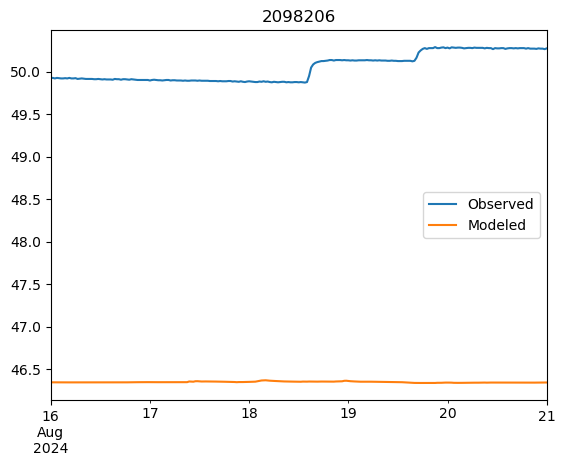

In [112]:
merged_df.plot(title=data_source_id)